In [44]:
%load_ext autoreload
%autoreload 2
# from google.colab import drive
# drive.mount('/content/gdrive')
import os
import sys
# from google.colab import drive
# drive.mount('/content/drive')
# sys.path.append('/content/drive/MyDrive/Projects/2023-HJ-Prox/src/')


sys.path.append('/home/sh2146/pinns')

354
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [45]:
# # cd/content/gdrive/My Drive/pinns
# cd/home/sh2146/pinns

In [46]:
import argparse
import torch
import torch.nn as nn
import data
import utils
# import importlib
# importlib.reload(utils)
import model
import numpy as np
from tqdm import tqdm
import scipy.io
import matplotlib.pyplot as plt

### 1. Default Setting

1. Domain: 100 x 256 ($x \in [-1,1]$ and $t \in [0,1]$)

2. Collocation points: $N_{ic}=256$ and $N_{f}=25600$

3. Optimizer: Adam with the learning rate of $10^{-3}$


In [47]:
num_t = 100
num_x = 256
num_epochs = 20000
num_hidden = 4
num_nodes = 128
lr = 1e-2 #0.001

In [48]:
# Select a partial differential equation
# eq = 'ac'  or 'bg' or 'hj' or 'bshj'
eq = 'bshj'

### 2. Train Data

In [49]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print("Operation mode: ", device)

Operation mode:  cuda:1


In [50]:
if eq == 'bg':
    t_data, x_data, u_data, t_data_f, x_data_f = data.bg_generator(num_t, num_x)  
elif eq == 'ac':
    t_data, x_data, u_data, t_data_f, x_data_f = data.ac_generator(num_t, num_x)
elif eq == 'hj':
    t_data, x_data, u_data, t_data_f, x_data_f = data.hj_generator(num_t, num_x)
elif eq == 'bshj':
    t_data, x_data, u_data, t_data_f, x_data_f = data.bs_entropy_hj_generator(num_t, num_x)
else:
    print("There exists no the equation.")
    exit(0)
# print(eq)

In [51]:
variables = torch.FloatTensor(np.concatenate((t_data, x_data), 1)).to(device)
variables_f = torch.FloatTensor(np.concatenate((t_data_f, x_data_f), 1)).to(device)
variables_f.requires_grad = True
u_data = torch.FloatTensor(u_data).to(device)

### 3. Neural Network

In [52]:
layer_list = [2] + num_hidden * [num_nodes] + [1]
pinn = model.pinn(layer_list).to(device)

### 4. Training Session

In [53]:
optimizer = torch.optim.Adam(pinn.parameters(), betas=(0.999,0.999), lr=lr)
loss_graph = []
ls = 10
bep = 0

In [54]:
def hj_equation(u, tx):
    u_tx = fwd_gradients(u, tx)
    u_t = u_tx[:, 0:1]
    u_x = u_tx[:, 1:2]
    # e= u_t + 0.5* np.linalg.norm(u_x)**2
    e = u_t + 1/2*(u_x)**2
    return e

def bs_entropy_hj_equation(u, tx):
    u_tx = fwd_gradients(u, tx)
    u_t = u_tx[:, 0:1]
    u_x = u_tx[:, 1:2]
    t=tx[:,0:1]
    x=tx[:,1:2]
    e= u_t + 1/t**2 *((x-t/x*u_x*torch.log(1-t/x**2*u_x)+t/x*u_x))
    return e 


    
optimizer.zero_grad()

# Full batch
u_hat = pinn(variables)
u_hat_f = pinn(variables_f)

if eq == 'bg':
    loss_f = torch.mean(utils.burgers_equation(u_hat_f, variables_f) ** 2)
elif eq == 'ac':
    loss_f = torch.mean(utils.ac_equation(u_hat_f, variables_f) ** 2)
elif eq == 'hj':
    loss_f = torch.mean(utils.hj_equation(u_hat_f, variables_f) ** 2)
elif eq == 'bshj':
    loss_f = torch.mean(utils.bs_entropy_hj_equation(u_hat_f, variables_f) ** 2)


# loss_u = torch.mean((u_hat - u_data) ** 2) # gives the loss of initial/boundary conditions

loss = loss_f # + loss_u

# print(u_hat)
# print(u_hat_f)
# print(variables_f[:,0:1].shape)
# print(variables)
# print(variables_f)
print(loss.item())

0.02716083452105522


In [55]:
for ep in tqdm(range(num_epochs)):
        
        optimizer.zero_grad()
        
        # Full batch
        u_hat = pinn(variables)
        u_hat_f = pinn(variables_f)
        
        if eq == 'bg':
            loss_f = torch.mean(utils.burgers_equation(u_hat_f, variables_f) ** 2)
        elif eq == 'ac':
            loss_f = torch.mean(utils.ac_equation(u_hat_f, variables_f) ** 2)
        elif eq == 'hj':
            loss_f = torch.mean(utils.hj_equation(u_hat_f, variables_f) ** 2)
        elif eq == 'bshj':
            loss_f = torch.mean(utils.bs_entropy_hj_equation(u_hat_f, variables_f) ** 2)
        
        # loss_u = torch.mean((u_hat - u_data) ** 2)
        loss = loss_f  # + loss_u
        loss.backward() 
        optimizer.step()
        
        l = loss.item()
        loss_graph.append(l)
        if l < ls:
            ls = l
            bep = ep
            torch.save(pinn.state_dict(), './'+eq+'_1d.pth')
            
        if ep % 1000 == 0:
            print(f"Train loss: {l}") 

  0%|          | 0/20000 [00:00<?, ?it/s]

  0%|          | 16/20000 [00:00<02:10, 153.40it/s]

Train loss: 0.010614434257149696


  5%|▌         | 1017/20000 [00:07<02:12, 142.83it/s]

Train loss: 0.014077108353376389


 10%|█         | 2020/20000 [00:14<02:06, 142.02it/s]

Train loss: 0.0046591442078351974


 15%|█▌        | 3022/20000 [00:21<02:01, 140.22it/s]

Train loss: 0.007663180585950613


 20%|██        | 4019/20000 [00:28<01:51, 142.87it/s]

Train loss: 0.003582577919587493


 25%|██▌       | 5019/20000 [00:35<01:54, 130.34it/s]

Train loss: 0.0015980282332748175


 30%|███       | 6026/20000 [00:43<01:39, 140.05it/s]

Train loss: 0.0005697782034985721


 35%|███▌      | 7019/20000 [00:50<01:32, 140.90it/s]

Train loss: 0.00013559097715187818


 40%|████      | 8025/20000 [00:57<01:26, 138.24it/s]

Train loss: 0.00010021797788795084


 45%|████▌     | 9026/20000 [01:05<01:20, 135.80it/s]

Train loss: 3.185549576301128e-05


 50%|█████     | 10015/20000 [01:12<01:11, 139.36it/s]

Train loss: 1.7609647329663858e-05


 55%|█████▌    | 11028/20000 [01:19<01:04, 139.03it/s]

Train loss: 1.771328243194148e-05


 60%|██████    | 12020/20000 [01:26<00:57, 139.56it/s]

Train loss: 8.414303920289967e-06


 65%|██████▌   | 13025/20000 [01:34<00:52, 133.50it/s]

Train loss: 6.2690660342923366e-06


 70%|███████   | 14013/20000 [01:41<00:45, 132.69it/s]

Train loss: 4.376027391117532e-06


 75%|███████▌  | 15017/20000 [01:48<00:37, 132.86it/s]

Train loss: 3.0266137400758453e-06


 80%|████████  | 16019/20000 [01:56<00:28, 137.86it/s]

Train loss: 2.3815564418327995e-06


 85%|████████▌ | 17024/20000 [02:03<00:23, 129.02it/s]

Train loss: 1.8891281570176943e-06


 90%|█████████ | 18020/20000 [02:11<00:16, 122.50it/s]

Train loss: 1.3396172562352149e-06


 95%|█████████▌| 19015/20000 [02:20<00:07, 127.12it/s]

Train loss: 9.020891411637422e-07


100%|██████████| 20000/20000 [02:27<00:00, 135.44it/s]


[Best][Epoch: 19995] Train loss: 6.600125175282301e-07


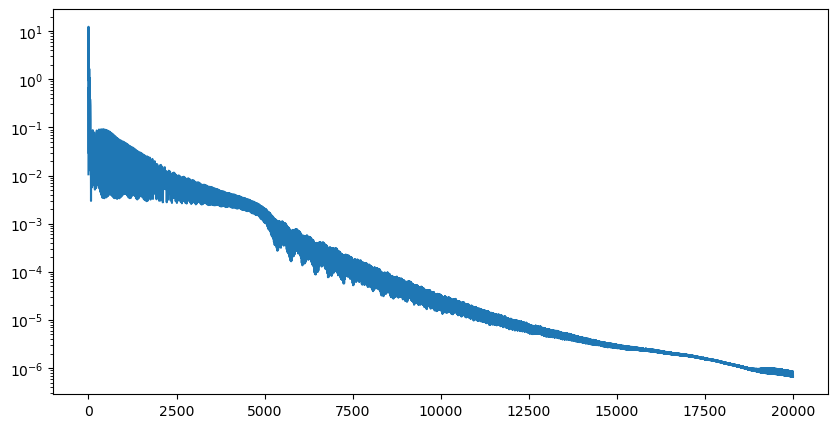

In [56]:
print(f"[Best][Epoch: {bep}] Train loss: {ls}") 
plt.figure(figsize=(10, 5))
plt.plot(loss_graph)
plt.yscale('log')
plt.show()

### 5. Inference Session

In [57]:
pinn.load_state_dict(torch.load('./'+eq+'_1d.pth'))

<All keys matched successfully>

In [58]:
# def hj_exact(x,y): #use this if i.c. is L2
#     f = torch.zeros(256, 101)
#     for j in range(len(y)):
#         for i in range(len(x)):
#                 f[i,j] = x[i]**2/(2*y[j]+1)
#     return f

        
def hj_exact(x,y): #use this if i.c. is L1
    f = torch.zeros(256, 101)
    for j in range(len(y)):
        for i in range(len(x)):
            if torch.absolute(x[i])<y[j]:
                f[i,j] = 1/(2*y[j])*x[i]**2
            else:
                f[i,j] = torch.absolute(x[i])-y[j]/2
    return f

interval_x = torch.arange(0,1, 1/256)
# #print(interval_x)
interval_t = torch.arange(0,1, 1/100)
# #print(interval_t)

# interval = torch.stack((interval_x, interval_t), 1)
# print(interval)

#interval = torch.cartesian_prod(interval_x, interval_t)
#print(interval[0, 1])

#data = torch.tensor(list(map(f, interval_x, interval_t)))

def bshj_exact(X,T):
    M=torch.zeros(256,101)
    for j in range(len(T)):
        t=T[j]
        for i in range(len(X)):
            x=X[i]
            if 0<x and x<0.5*np.exp(-t):
                M[i,j] = 1/2+x*(1-np.exp(t))/t
            elif x>0.5*np.exp(t):
                M[i,j] =-1/2+x*(1-np.exp(-t))/t
            elif t==0:
                if x>0.5:
                    M[i,j]=x-0.5
                if x<=0.5:
                    M[i,j]=0.5-x
                
            else:
                M[i,j] = (2*x-np.log(x)-1-np.log(2))/(2*t)
    return M

# d = bshj_exact(interval_x, interval_t)



In [59]:
if eq =='bshj':
    t_test, x_test = data.bs_entropy_hj_generator(101, 256, typ='test')
    t = np.linspace(0.01,1, 101).reshape(-1,1)
    x = np.linspace(0.0001, 1, 256).reshape(-1,1)
    T = t.shape[0]
    N = x.shape[0]
    test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
    with torch.no_grad():
        u_pred = pinn(test_variables)
    u_pred = u_pred.cpu().numpy().reshape(N,T)

    # reference data
    d = bshj_exact(x.flatten(), t.flatten())
    Exact = d.cpu().numpy().reshape(N,T)
    err = u_pred[:,:-1]-Exact[:,:-1]
    
    
if eq == 'hj':       
    t_test, x_test = data.hj_generator(101, 256, typ='test')
    t = np.linspace(0, 1, 101).reshape(-1,1)
    x = np.linspace(-1, 1, 256).reshape(-1,1)
    T = t.shape[0]
    N = x.shape[0]
    test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
    with torch.no_grad():
        u_pred = pinn(test_variables)
    u_pred = u_pred.cpu().numpy().reshape(N,T)
    
    # reference data
    d = hj_exact(interval_x, interval_t)
    # Exact = np.real(data['usol']) 
    Exact = d.cpu().numpy().reshape(N,T)
    print(Exact.shape)
    # data = scipy.io.loadmat('./data/burgers_shock.mat')  
    # Exact = np.real(data['usol'])  
    err = u_pred[:,:-1]-Exact[:,:-1]
    
    
    

if eq == 'bg':       
    t_test, x_test = data.bg_generator(101, 256, typ='test')
    t = np.linspace(0, 1, 101).reshape(-1,1)
    x = np.linspace(-1, 1, 256).reshape(-1,1)
    T = t.shape[0]
    N = x.shape[0]
    test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
    with torch.no_grad():
        u_pred = pinn(test_variables)
    u_pred = u_pred.cpu().numpy().reshape(N,T)

    # reference data
    data = scipy.io.loadmat('./data/burgers_shock.mat')  
    Exact = np.real(data['usol'])  
    err = u_pred[:,:-1]-Exact
    
elif eq == 'ac':
    t = np.linspace(0, 1, 201).reshape(-1,1) # T x 1
    x = np.linspace(-1, 1, 513)[:-1].reshape(-1,1) # N x 1
    T = t.shape[0]
    N = x.shape[0]
    T_star = np.tile(t, (1, N)).T  # N x T
    X_star = np.tile(x, (1, T))  # N x T
    t_test = T_star.flatten()[:, None]
    x_test = X_star.flatten()[:, None]
    
    test_variables = torch.FloatTensor(np.concatenate((t_test, x_test), 1)).to(device)
    with torch.no_grad():
        u_pred = pinn(test_variables)
    u_pred = u_pred.cpu().numpy().reshape(N,T)

    # reference data
    data = scipy.io.loadmat('./data/AC.mat')
    Exact = np.real(data['uu'])
    err = u_pred-Exact

# print(u_pred)
err = np.linalg.norm(err,2)/np.linalg.norm(Exact,2)   
print(f"L2 Relative Error: {err}")

L2 Relative Error: 0.9049182534217834


### 6. Result Figures

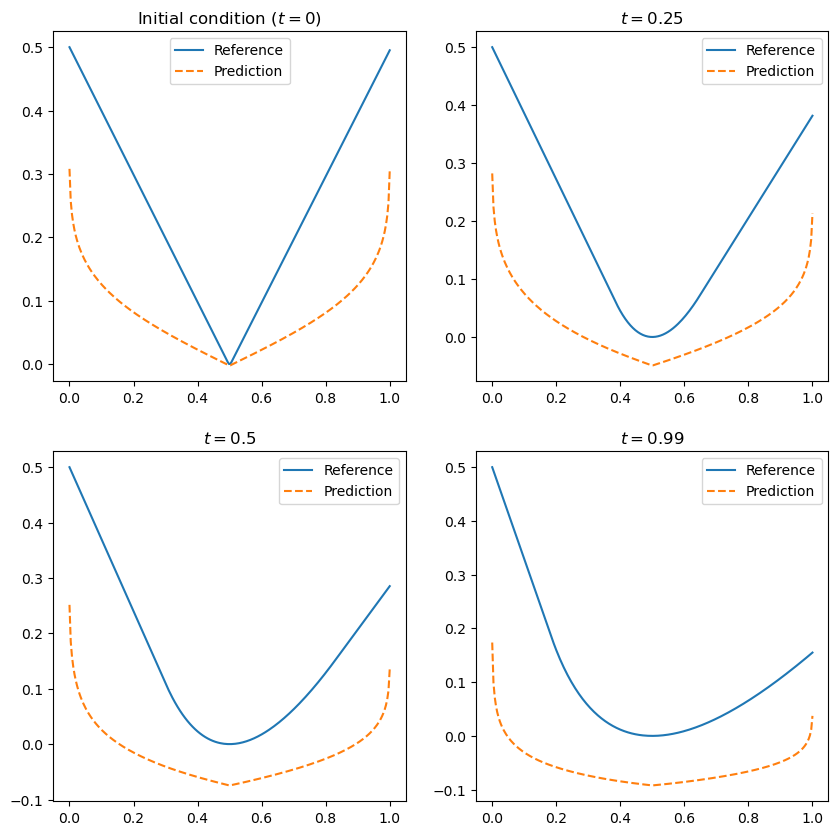

In [60]:
utils.resplot(x, t, t_data, x_data, Exact, u_pred)

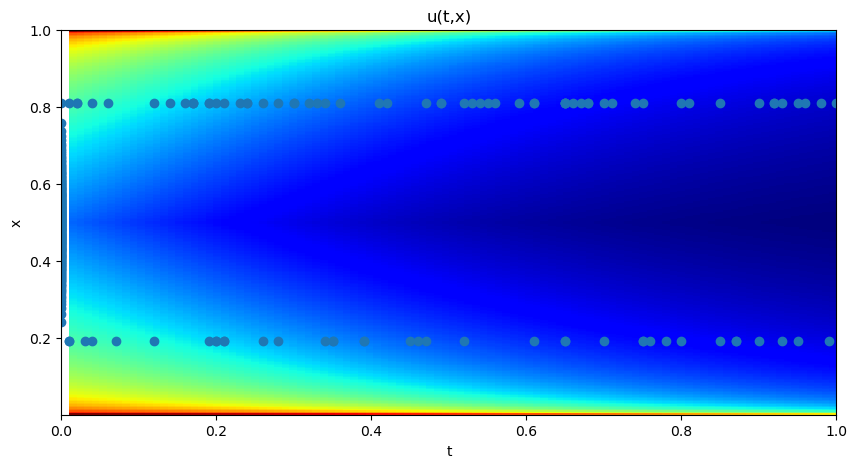

In [61]:
plt.figure(figsize=(10, 5))
plt.imshow(u_pred, interpolation='nearest', cmap='jet',
            extent=[t.min(), t.max(), x.min(), x.max()],
            origin='lower', aspect='auto')
# plt.clim(-1, 1)
# plt.ylim(-1,1)
plt.xlim(0,1)
plt.scatter(t_data, x_data)
plt.xlabel('t')
plt.ylabel('x')
plt.title('u(t,x)')
plt.show()